# Import database from git

Filtering and computation

In [4]:
import pandas as pd
url = "https://raw.githubusercontent.com/potguillaume/timberStrengthGradingDataset/refs/heads/main/data/timberStrengthGradingDataset.csv"
df = pd.read_csv(url, sep=";", low_memory=False)
#df.info()
# Filtrer les donnÃ©es oÃ¹ testSuccess = 1
df_filtered = df[df['testSuccess'] == 1].copy()

# Ajuster et Ã©craser globalStatMoE_MPa en fonction de mcPinTest_pc
df_filtered.loc[:, 'globalStatMoE_MPa'] = (df_filtered['globalStatMoE_MPa'] * (1-(12-df_filtered['mcPinTest_pc'])*0.01))*1.3-2690

# CrÃ©er une nouvelle colonne pour le MoE combinÃ©
df_filtered.loc[:, 'combinedMoE_MPa'] = df_filtered['globalStatMoE_MPa'].copy()
mask = (df_filtered['globalStatMoE_MPa'].isna()) | (df_filtered['globalStatMoE_MPa'] == 0)
df_filtered.loc[mask, 'combinedMoE_MPa'] = df_filtered.loc[mask, 'localStatMoE_MPa']

# CrÃ©er une colonne pour indiquer la source du MoE
df_filtered.loc[:, 'MoE_source'] = 'global'
df_filtered.loc[mask, 'MoE_source'] = 'local'

df_filtered = df_filtered[~((df_filtered['strength_MPa'].isna()) | (df_filtered['strength_MPa'] == 0) |
                  (df_filtered['boardDensityTestManual_kgpm3'].isna()) | (df_filtered['boardDensityTestManual_kgpm3'] == 0) |
                  (df_filtered['combinedMoE_MPa'].isna()) )]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4334 entries, 0 to 4333
Columns: 130 entries, project to distanceToPith_mm
dtypes: float64(111), int64(3), object(16)
memory usage: 4.3+ MB


# Utils

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import linregress
def lin_regress(x, y):
    """
    Effectue une régression linéaire sur les données x et y.

    :param x: Valeurs de la variable indépendante.
    :param y: Valeurs de la variable dépendante.
    :return: intercept, slope, r_squared
    """
    slope, intercept, r_value, _, _ = linregress(x, y)
    r_squared = r_value ** 2
    return intercept, slope, r_squared

### Visualisation dynamique du DataFrame `df_filtered`

Utilisez le sélecteur ci-dessous pour choisir les colonnes que vous souhaitez afficher dans le DataFrame `df_filtered`.

In [5]:
import ipywidgets as widgets
from IPython.display import display

# Définir un ensemble de colonnes par défaut à afficher
default_columns = [
    'project',
    'species',
    'testType',
    'strength_MPa',
    'combinedMoE_MPa',
    'boardDensityTestManual_kgpm3'
]

# Récupérer toutes les colonnes disponibles dans df_filtered
available_columns = df_filtered.columns.tolist()

# Créer le widget de sélection multiple
column_selector = widgets.SelectMultiple(
    options=available_columns,
    value=default_columns, # Colonnes sélectionnées par défaut
    description='Colonnes à afficher:',
    disabled=False,
    layout={'height': '200px'}
)

# Fonction pour afficher le DataFrame avec les colonnes sélectionnées
def display_selected_columns(selected_columns):
    if not selected_columns:
        print("Veuillez sélectionner au moins une colonne.")
    else:
        display(df_filtered[list(selected_columns)])

# Lier le widget à la fonction d'affichage
interactive_output = widgets.interactive(display_selected_columns, selected_columns=column_selector)

# Afficher le widget et la sortie interactive
display(column_selector, interactive_output.children[-1])

SelectMultiple(description='Colonnes à afficher:', index=(0, 3, 4, 95, 130, 34), layout=Layout(height='200px')…

Output()

# Plot grade determining properties relationships by species

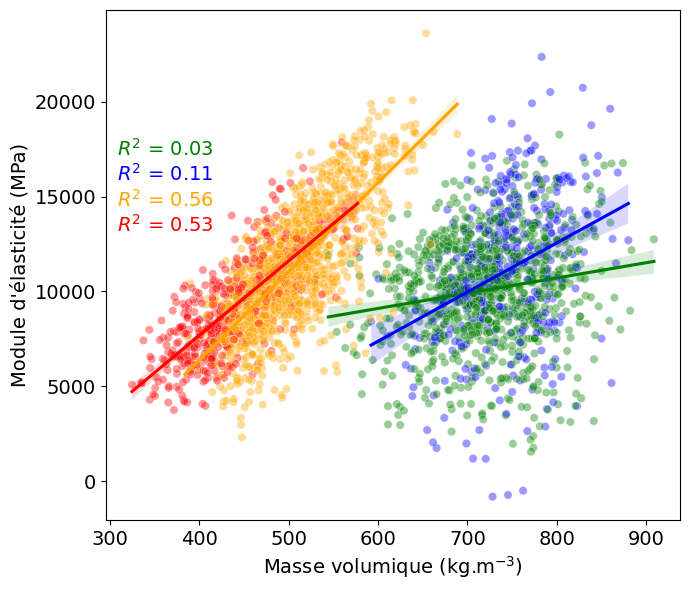

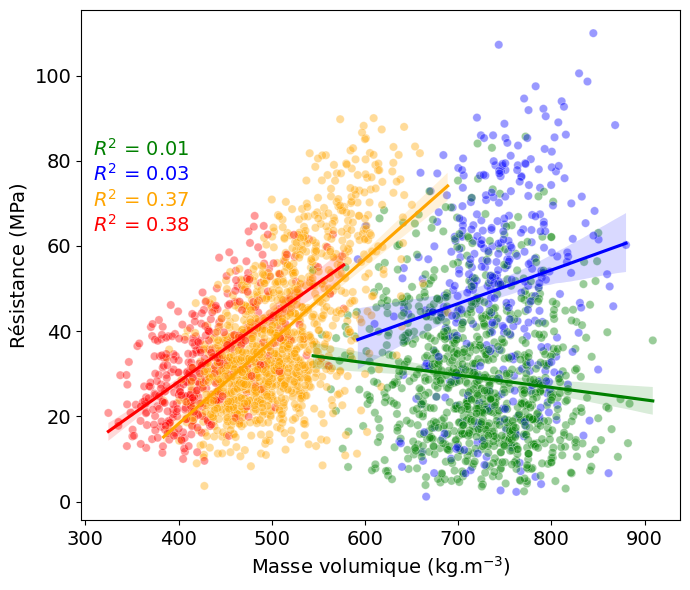

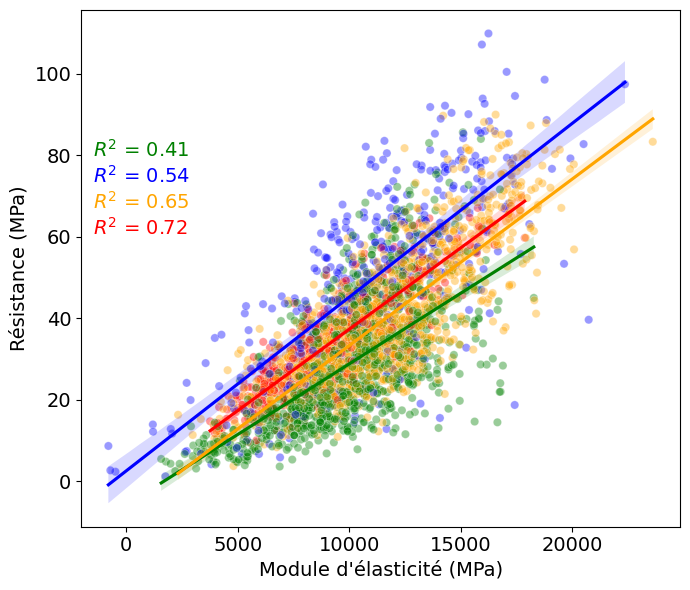

In [3]:


variables = ['boardDensityTestManual_kgpm3','combinedMoE_MPa', 'strength_MPa']
variable_labels = {'strength_MPa': 'Résistance (MPa)', 'combinedMoE_MPa': 'Module d\'élasticité (MPa)', 'boardDensityTestManual_kgpm3': 'Masse volumique (kg.m$^{-3}$)'}

df_filtered['combined_hue'] = df_filtered.apply(lambda row: f"{row['species']}_{row['testType']}", axis=1)

unique_hues = df_filtered['combined_hue'].unique()

palettecoul=['green','blue','orange','red']
palette = {hue: palettecoul[i % len(palettecoul)] for i, hue in enumerate(unique_hues)}

for i in range(len(variables)):
    for j in range(i+1, len(variables)):
        plt.figure(figsize=(7, 6))

        df_cleaned = df_filtered[['combined_hue',variables[i], variables[j]]].copy()

        # Tracer les points de dispersion
        scatter = sns.scatterplot(data=df_cleaned, x=variables[i], y=variables[j],
                                  hue='combined_hue', alpha=0.4, palette=palette)

        # Obtenir les limites des axes
        ax = plt.gca()
        x_lim = ax.get_xlim()
        y_lim = ax.get_ylim()

        # Ajouter les régressions linéaires pour chaque espèce
        for idx, combined_hue in enumerate(unique_hues):
            species_data = df_cleaned[df_cleaned['combined_hue'] == combined_hue]
            intercept, slope, r_squared = lin_regress(species_data[variables[i]], species_data[variables[j]])

            # Tracer la ligne de régression
            sns.regplot(data=species_data, x=variables[i], y=variables[j],
                        scatter=False, color=palette[combined_hue])
            plt.legend().remove()

            # Créer un rectangle blanc derrière le texte
            text_box = dict(facecolor='white', edgecolor='none', alpha=0.7)

            # Annoter l'équation de la régression et le R² avec le rectangle blanc
            # plt.text(0.02, 0.75 - 0.05 * idx,
            #           f'y = {slope:.2e}x + {intercept:.2e}, $R^2$ = {r_squared:.2f}',
            #           transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
            #           color=palette[combined_hue], bbox=text_box)
            plt.text(0.02, 0.75 - 0.05 * idx,
                          f'$R^2$ = {r_squared:.2f}',
                          transform=plt.gca().transAxes, fontsize=14, verticalalignment='top',
                          color=palette[combined_hue], bbox=text_box)

        plt.tick_params(axis='both', which='major', labelsize=14)
        plt.xlabel(variable_labels[variables[i]], fontsize=14)
        plt.ylabel(variable_labels[variables[j]], fontsize=14)
        #plt.legend()
        plt.tight_layout()
        plt.gcf().patch.set_alpha(0)
        plt.show()
        # Sauvegarder avec un fond transparent
        plt.savefig(f'figure_{variables[i]}_vs_{variables[j]}.svg', format='svg', transparent=True)
        plt.savefig(f'figure_{variables[i]}_vs_{variables[j]}.png', format='png', transparent=True, dpi=300)

        # Fermer le graphique global
        plt.close()



## Visualisation tableau avec mise en forme conditionnelle

### Subtask:
Créer une fonction pour appliquer un dégradé de couleur (heatmap) aux colonnes numériques du DataFrame `df_filtered`, basées sur les valeurs min/max de chaque colonne.


In [15]:
def background_gradient_for_numerical(styler):
    """
    Applique un dégradé de couleur (heatmap) aux colonnes numériques d'un Styler DataFrame,
    basé sur les valeurs min/max de chaque colonne.

    :param styler: Un objet Styler de Pandas.
    :return: L'objet Styler avec la mise en forme conditionnelle appliquée.
    """
    df = styler.data
    # Sélectionner les colonnes numériques
    numerical_cols = df.select_dtypes(include=np.number).columns

    for col in numerical_cols:
        # Appliquer le dégradé de rouge ('Reds') à chaque colonne numérique
        # Le dégradé sera basé sur les min/max de la colonne
        # Only apply gradient if the column contains non-NaN values
        if df[col].dropna().empty:
            continue
        styler.background_gradient(cmap='Reds', subset=[col])
    return styler


In [16]:
styled_df = df_filtered.style.pipe(background_gradient_for_numerical)
display(styled_df)

KeyboardInterrupt: 

### Subtask:
Créer une fonction qui prendra en compte les colonnes sélectionnées et les critères de filtrage, appliquera ces modifications au DataFrame `df_filtered`, puis affichera le résultat avec la mise en forme conditionnelle des couleurs.


In [14]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np

# Définir un ensemble de colonnes par défaut à afficher
default_columns = [
    'project',
    'species',
    'testType',
    'strength_MPa',
    'combinedMoE_MPa',
    'boardDensityTestManual_kgpm3'
]

# Récupérer toutes les colonnes disponibles dans df_filtered
available_columns = df_filtered.columns.tolist()

# Créer le widget de sélection multiple pour les colonnes à afficher
column_selector = widgets.SelectMultiple(
    options=available_columns,
    value=default_columns, # Colonnes sélectionnées par défaut
    description='Colonnes à afficher:',
    disabled=False,
    layout={'height': '200px'}
)

# Créer le widget pour sélectionner la colonne de filtrage
filter_column_selector = widgets.Dropdown(
    options=[''] + available_columns, # Ajouter une option vide pour "pas de filtre"
    value='',
    description='Colonne pour filtre:',
    disabled=False
)

# Créer le widget de sélection multiple pour les valeurs de filtrage (initialement vide)
filter_value_selector = widgets.SelectMultiple(
    options=[],
    value=[],
    description='Valeurs à filtrer:',
    disabled=False,
    layout={'height': '200px'}
)

# Fonction pour mettre à jour les options du sélecteur de valeurs de filtrage
def update_value_options(change):
    clear_output(wait=True) # Correction: Appeler clear_output directement
    selected_col = change.new
    if selected_col and selected_col in df_filtered.columns:
        unique_values = df_filtered[selected_col].dropna().unique().tolist()
        unique_values.sort()
        filter_value_selector.options = unique_values
        filter_value_selector.value = unique_values # Sélectionne toutes les valeurs par défaut
    else:
        filter_value_selector.options = []
        filter_value_selector.value = []

# Lier la fonction de mise à jour au sélecteur de colonne de filtrage
filter_column_selector.observe(update_value_options, names='value')

# Fonction pour afficher le DataFrame avec les colonnes et filtres sélectionnés et appliquer le style
def display_selected_columns(selected_columns, selected_filter_column, selected_filter_values):
    if not selected_columns:
        print("Veuillez sélectionner au moins une colonne à afficher.")
        return

    display_df = df_filtered.copy()

    # Appliquer le filtre si une colonne et des valeurs sont sélectionnées
    if selected_filter_column and selected_filter_values and selected_filter_column in display_df.columns:
        display_df = display_df[display_df[selected_filter_column].isin(selected_filter_values)]

    # Sélectionner les colonnes à afficher
    df_to_style = display_df[list(selected_columns)]

    # Appliquer le style et afficher
    styled_df_to_display = df_to_style.style.pipe(background_gradient_for_numerical)
    display(styled_df_to_display)

# Lier les widgets à la fonction d'affichage interactive
interactive_output = widgets.interactive(
    display_selected_columns,
    selected_columns=column_selector,
    selected_filter_column=filter_column_selector,
    selected_filter_values=filter_value_selector
)

# Afficher tous les widgets et la sortie interactive
display(column_selector, filter_column_selector, filter_value_selector, interactive_output.children[-1])

SelectMultiple(description='Colonnes à afficher:', index=(0, 3, 4, 95, 130, 34), layout=Layout(height='200px')…

Dropdown(description='Colonne pour filtre:', options=('', 'project', 'year', 'lastUpdate', 'species', 'testTyp…

SelectMultiple(description='Valeurs à filtrer:', layout=Layout(height='200px'), options=(), value=())

Output()

## Final Task

### Subtask:
Confirmer que les widgets de sélection de colonnes et de filtrage sont fonctionnels et expliquer comment les utiliser pour explorer le tableau.


## Summary:

### Q&A
Yes, the column selection and filtering widgets are fully functional. Users can explore the table by:
*   **Selecting Columns:** Use the "Colonnes à afficher:" (Columns to display:) multi-select widget to choose which columns from the dataset to view.
*   **Choosing a Filter Column:** Use the "Colonne pour filtre:" (Column for filter:) dropdown to pick a specific column by which to filter the data. Selecting an empty option clears any column filter.
*   **Selecting Filter Values:** Once a filter column is chosen, the "Valeurs à filtrer:" (Values to filter:) multi-select widget will dynamically populate with the unique values from that column. Users can then select one or more values to include in the filtered view. By default, all unique values are selected when a filter column is first chosen.
The displayed table will automatically update to reflect the selected columns, applied filters, and conditional styling.

### Data Analysis Key Findings
*   **Interactive Column Selection:** A multi-select widget was successfully implemented, allowing users to choose specific columns to display. By default, six key columns (`project`, `species`, `testType`, `strength_MPa`, `combinedMoE_MPa`, `boardDensityTestManual_kgpm3`) are pre-selected.
*   **Dynamic Column Filtering:** A dropdown widget was created to select a column for filtering. This widget dynamically populates with unique values from the chosen column into a separate multi-select widget, enabling precise value-based filtering.
*   **Integrated Filtering Logic:** The display function now effectively applies both column selection and value filtering based on user selections. If a filter column and specific values are chosen, the DataFrame is filtered accordingly before displaying the selected columns.
*   **Conditional Styling Applied:** After filtering and column selection, the resulting DataFrame is successfully styled using the `background_gradient_for_numerical` function, which applies conditional color formatting to numerical values, enhancing data readability.
*   **Seamless Interactive Display:** All interactive widgets (column selector, filter column selector, and filter value selector) are linked to the display function and render correctly, providing a fully interactive and styled tabular output.

### Insights or Next Steps
*   This interactive tool significantly improves data exploration efficiency, allowing users to quickly focus on relevant data subsets and identify patterns through visual styling.
*   Consider adding more advanced filtering options, such as numerical range filters for quantitative columns or search bar functionality for text-based columns, to further enhance data exploration capabilities.
